### Classification

Use LM to classify articles into one/two pre-defined topics

In [23]:
import pandas as pd
import json

csv_path = "/Users/pql/Desktop/proj/gpt4o-topic-assignments.csv"
topic = pd.read_csv(csv_path)
# print(topic.head())

json_path = "/Users/pql/Desktop/proj/test_4o_mini_on_4o_questions_with_predictions.json"  # Replace with desired output path
with open(json_path, 'rb') as f:
    result_4o_mini_on_4o_Q = json.load(f)

df = result_4o_mini_on_4o_Q

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(df, orient="index")
df.index.name = "qid"
df.reset_index(inplace=True)

# Create binary match indicators for analysis
df["answer_match"] = df["model_answer"] == df["ground_truth_answer"]
df["discrepancy_match"] = df["model_discrepancy"] == df["ground_truth_discrepancy"]
df["evidence_quality_match"] = df["model_evidence-quality"] == df["ground_truth_evidence-quality"]

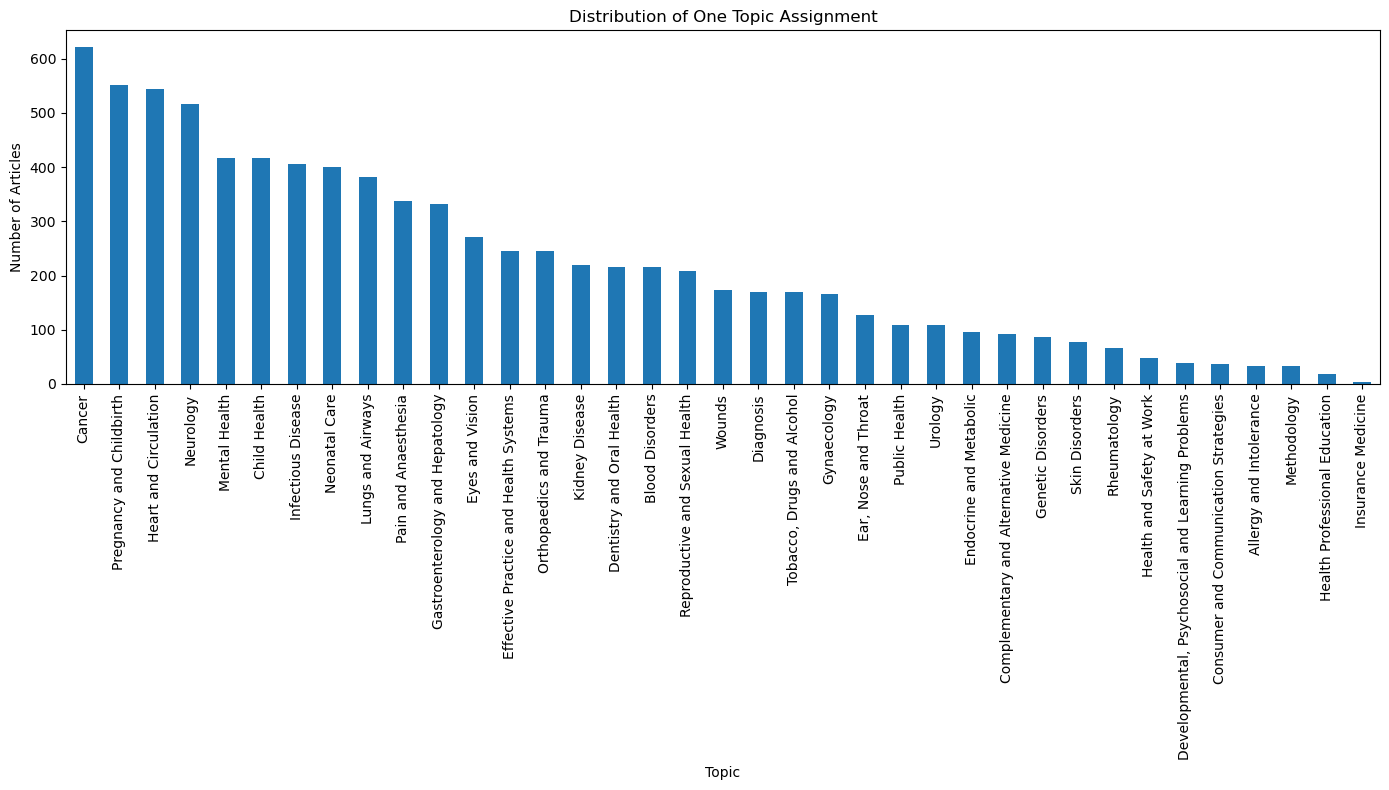

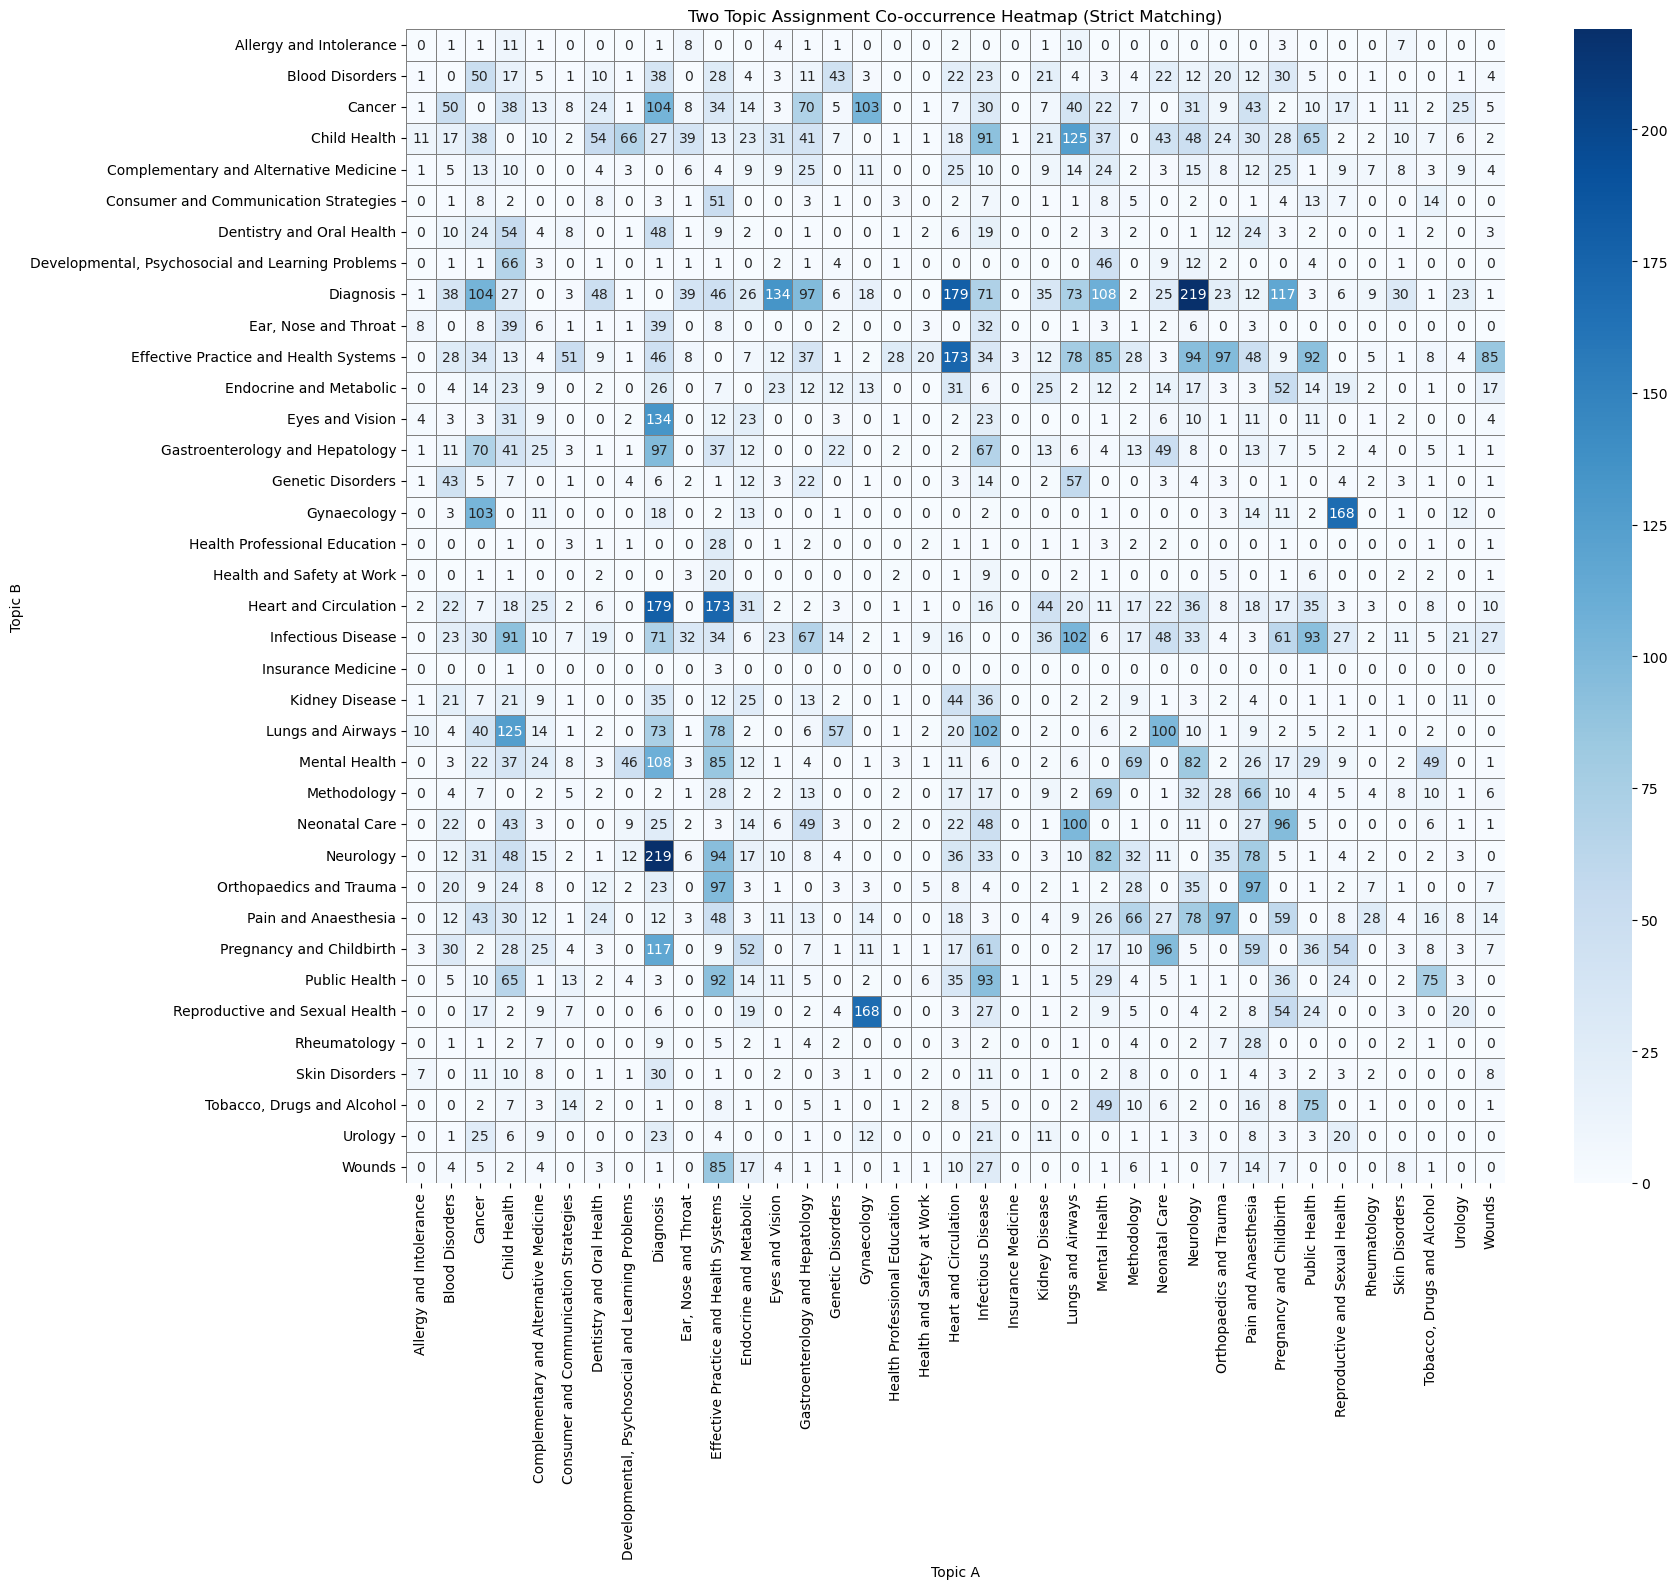

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Count the number of articles per topic
topic_counts = topic['one_topic_assignment'].value_counts()

# Plot
plt.figure(figsize=(14, 8))
topic_counts.plot(kind='bar')
plt.title('Distribution of One Topic Assignment')
plt.xlabel('Topic')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Full list of all known topics
topic_list = [
    "Allergy and Intolerance",
    "Blood Disorders",
    "Cancer",
    "Child Health",
    "Complementary and Alternative Medicine",
    "Consumer and Communication Strategies",
    "Dentistry and Oral Health",
    "Developmental, Psychosocial and Learning Problems",
    "Diagnosis",
    "Ear, Nose and Throat",
    "Effective Practice and Health Systems",
    "Endocrine and Metabolic",
    "Eyes and Vision",
    "Gastroenterology and Hepatology",
    "Genetic Disorders",
    "Gynaecology",
    "Health and Safety at Work",
    "Health Professional Education",
    "Heart and Circulation",
    "Infectious Disease",
    "Insurance Medicine",
    "Kidney Disease",
    "Lungs and Airways",
    "Mental Health",
    "Methodology",
    "Neonatal Care",
    "Neurology",
    "Orthopaedics and Trauma",
    "Pain and Anaesthesia",
    "Pregnancy and Childbirth",
    "Public Health",
    "Reproductive and Sexual Health",
    "Rheumatology",
    "Skin Disorders",
    "Tobacco, Drugs and Alcohol",
    "Urology",
    "Wounds"
]

# Match topics from two_topic_assignment
def extract_topics(text):
    found = []
    for topic_name in topic_list:
        if topic_name in str(text):
            found.append(topic_name)
    return found if len(found) == 2 else [None, None]

# Apply extraction
topic[['first_topic', 'second_topic']] = topic['two_topic_assignment'].apply(extract_topics).apply(pd.Series)

# Build a co-occurrence matrix
all_topics = sorted(set(topic_list))
co_matrix = pd.DataFrame(0, index=all_topics, columns=all_topics)

for _, row in topic.iterrows():
    t1, t2 = row['first_topic'], row['second_topic']
    if pd.notna(t1) and pd.notna(t2):
        co_matrix.at[t1, t2] += 1
        co_matrix.at[t2, t1] += 1  # Make it symmetric

# Plot the heatmap
plt.figure(figsize=(18, 16))
sns.heatmap(co_matrix, annot=True, fmt=".0f", cmap="Blues", linewidths=0.5, linecolor='gray')
plt.title("Two Topic Assignment Co-occurrence Heatmap (Strict Matching)")
plt.xlabel("Topic A")
plt.ylabel("Topic B")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**Observations:**

1. A few dominant topics (e.g., Cancer, Pregnancy and Childbirth, Heart and Circulation, Neurology) account for a large proportion of total samples, reflecting their clinical importance and systematic review prevalence.

2. Auxiliary fields like Allergy and Intolerance, Health Professional Education, and Insurance Medicine have very low representation.

3. There's strong connection between certain topic pairs. eg. "Reproductive and Sexual Health" and "Gynaecology"; "Neurology" and "Diagnosis"

4. Certain topics like "Diagnosis" or "Effective Practice and Health Systems" demonstrate high cross-topic connectivity.

Top 5 Topics with Highest Answer Match Rate:
                            answer_match  article_count
one_topic_assignment                                   
Rheumatology                    0.727273             66
Pain and Anaesthesia            0.688427            337
Tobacco, Drugs and Alcohol      0.686391            169
Public Health                   0.685185            108
Urology                         0.675926            108

Bottom 5 Topics with Lowest Answer Match Rate:
                                        answer_match  article_count
one_topic_assignment                                               
Health and Safety at Work                   0.541667             48
Complementary and Alternative Medicine      0.532609             92
Dentistry and Oral Health                   0.532407            216
Neonatal Care                               0.505000            400
Wounds                                      0.433526            173




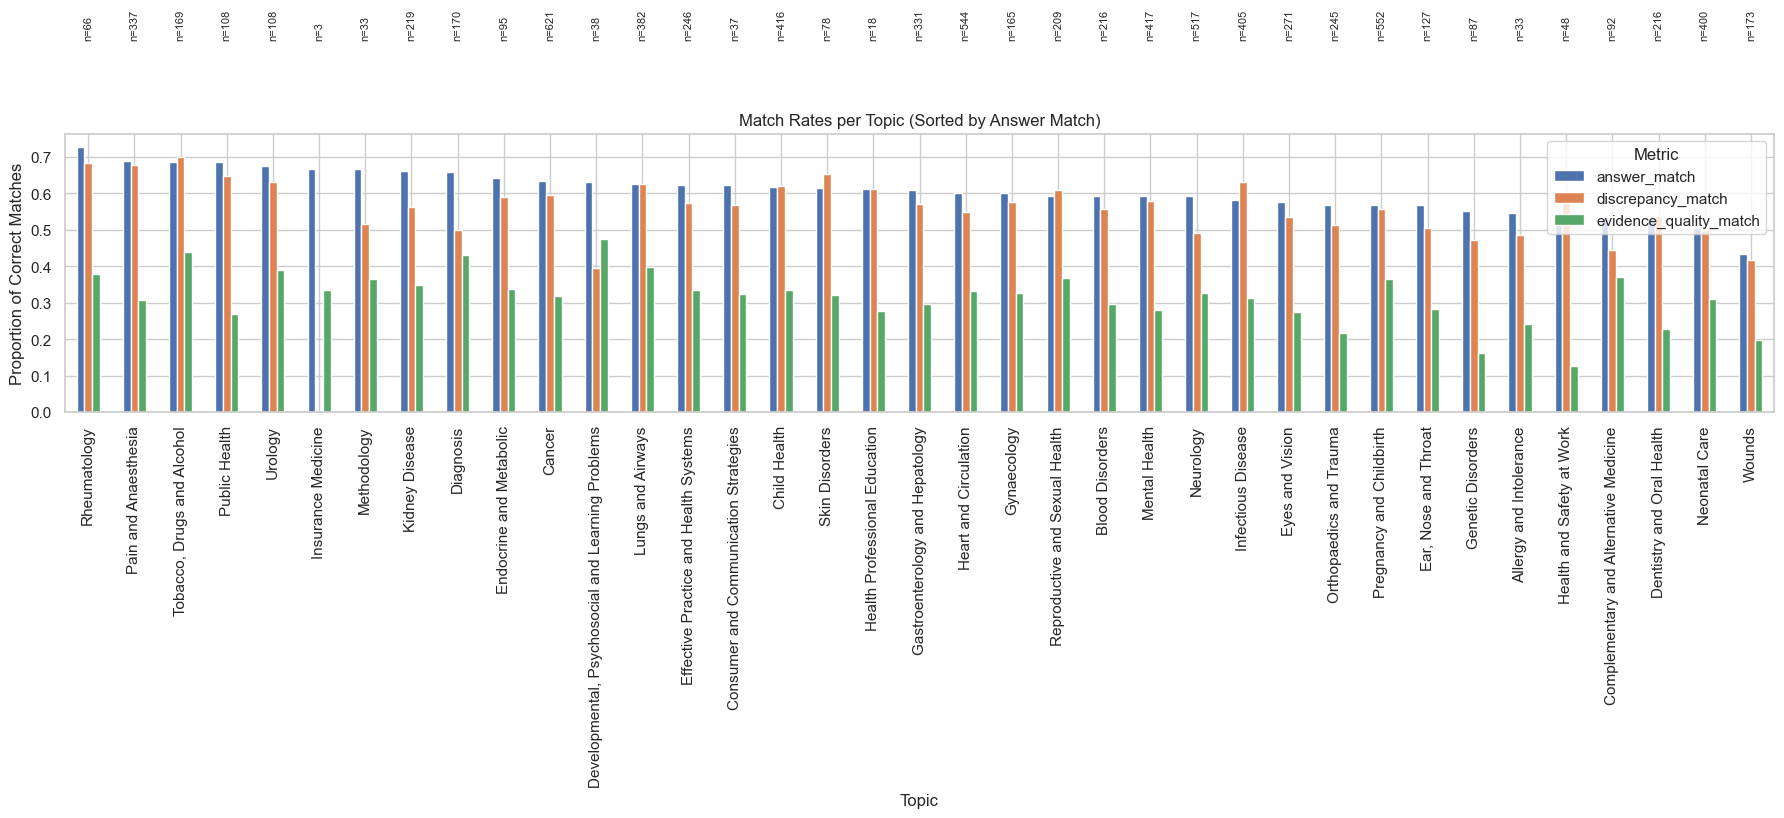

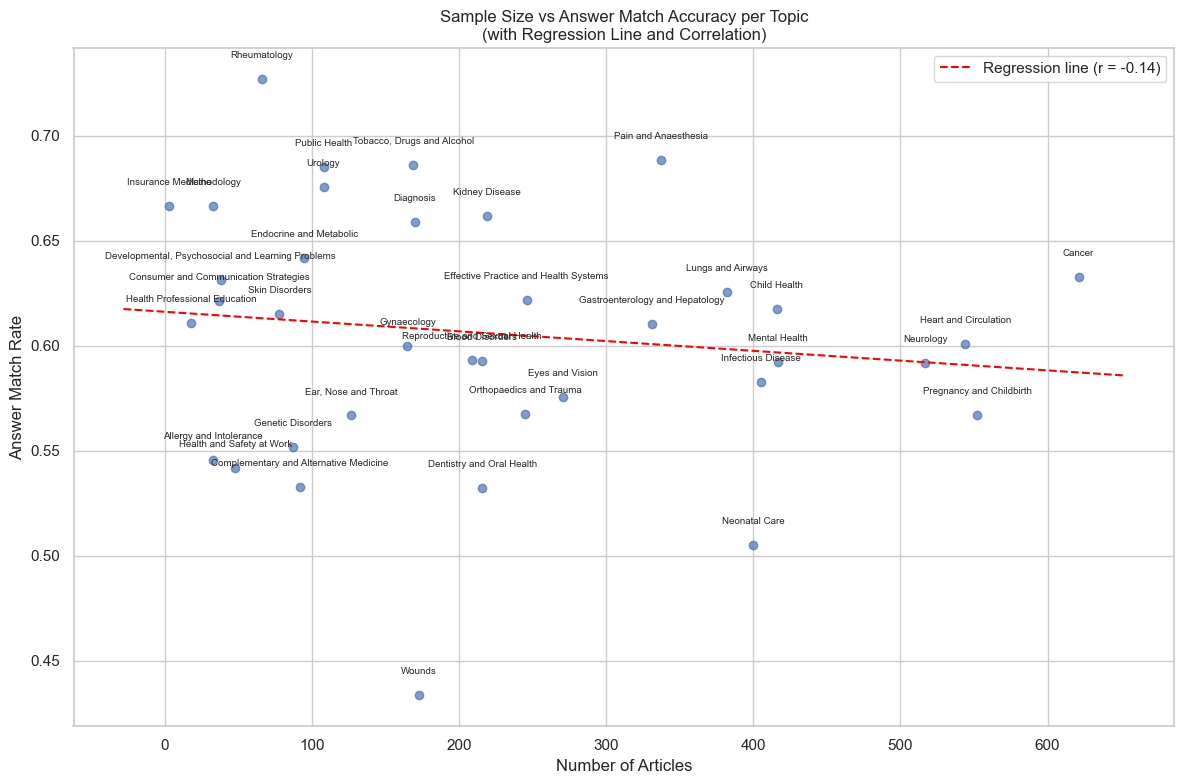

In [104]:
# Merge your answer-evaluation dataframe (df) with topic dataframe (topic) on 'doi'
df_with_topic = df.merge(topic[['doi', 'one_topic_assignment']], on='doi', how='left')



# Group by topic and calculate mean match rates
topic_accuracy = df_with_topic.groupby('one_topic_assignment')[['answer_match', 'discrepancy_match', 'evidence_quality_match']].mean()
topic_counts = df_with_topic['one_topic_assignment'].value_counts()

# Merge article counts
topic_accuracy['article_count'] = topic_counts

# Sort by answer_match
sorted_topic_accuracy = topic_accuracy.sort_values('answer_match', ascending=False)

# Top 5 Topics
top_topics = sorted_topic_accuracy.head(5)
print("Top 5 Topics with Highest Answer Match Rate:")
print(top_topics[['answer_match', 'article_count']])

# Bottom 5 Topics
bottom_topics = sorted_topic_accuracy.tail(5)
print("\nBottom 5 Topics with Lowest Answer Match Rate:")
print(bottom_topics[['answer_match', 'article_count']])
print("\n")







import matplotlib.pyplot as plt

# Group by topic: calculate mean match rates and article counts
topic_accuracy = df_with_topic.groupby('one_topic_assignment')[['answer_match', 'discrepancy_match', 'evidence_quality_match']].mean()
topic_counts = df_with_topic['one_topic_assignment'].value_counts()

# Merge article counts
topic_accuracy['article_count'] = topic_counts

# Sort ONLY by 'answer_match'
sorted_topic_accuracy = topic_accuracy.sort_values('answer_match', ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(18, 10))
sorted_topic_accuracy[['answer_match', 'discrepancy_match', 'evidence_quality_match']].plot(kind='bar', ax=ax)

# Annotate article counts above the bars
for idx, (label, row) in enumerate(sorted_topic_accuracy.iterrows()):
    ax.text(idx, 1.02, f'n={int(row["article_count"])}', ha='center', va='bottom', fontsize=8, rotation=90)

plt.title('Match Rates per Topic (Sorted by Answer Match)')
plt.ylabel('Proportion of Correct Matches')
plt.xlabel('Topic')
plt.xticks(rotation=90)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()



import matplotlib.pyplot as plt
from scipy.stats import linregress

# Group by topic
topic_accuracy = df_with_topic.groupby('one_topic_assignment')[['answer_match']].mean()
topic_counts = df_with_topic['one_topic_assignment'].value_counts()

# Merge counts into accuracy
topic_accuracy['article_count'] = topic_counts

# Scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(topic_accuracy['article_count'], topic_accuracy['answer_match'], alpha=0.7)

# Regression line
slope, intercept, r_value, p_value, std_err = linregress(topic_accuracy['article_count'], topic_accuracy['answer_match'])
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--', color='red', label=f'Regression line (r = {r_value:.2f})')

# Add labels
for idx, row in topic_accuracy.iterrows():
    plt.text(row['article_count'], row['answer_match'] + 0.01, idx, fontsize=7, ha='center')

plt.title('Sample Size vs Answer Match Accuracy per Topic\n(with Regression Line and Correlation)')
plt.xlabel('Number of Articles')
plt.ylabel('Answer Match Rate')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()








**Observations**

1. Highest accuracy observed in Rheumatology, Pain and Anaesthesia, Tobacco, Drugs and Alcohol, Public Health, Urology, all above 67%.

2. Lowest accuracy in Wounds (43%), Neonatal Care (50%), Dentistry and Oral Health (53%), Complementary and Alternative Medicine (53%), Health and Safety at Work (54%), reflecting domain complexity and evidence variability.

3. Most topics fall within a 55%–65% accuracy range, showing moderate performance overall.

4. No strong correlation between article count and accuracy (r = –0.14); more articles do not imply better performance.

5. Small-topic domains vary widely, while high-volume topics like Cancer and Pregnancy show stable but average accuracy.

### Negation

Update: exclded negated questions where (LM thinks) negated answer cannot be logically inferred from original question and answer

In [118]:
import json
import pandas as pd
negated = []
with open("/Users/pql/Desktop/proj/test-4o-negated-2.jsonl", "r") as f:
    for line in f:
        negated.append(json.loads(line))
# print(data)
negated_df = pd.DataFrame.from_dict(negated)
# negated_df.to_csv("negated_question.csv")
# negated_df

json_path = "/Users/pql/Desktop/proj/eval_on_negated_results.json"  # Replace with desired output path
with open(json_path, 'rb') as f:
    eval_negated = json.load(f)

eval_negated_df = pd.DataFrame.from_dict(eval_negated, orient="index")

# eval_negated_df

Total samples: 321
Inverse-consistent pairs: 235 (73.21%)
Identical answers (no change): 69 (21.50%)
Others (neither identical nor inverted): 17 (5.30%)

  model_answer_orig  total_transitions  correct_inversions   No  No Evidence  \
0                No                 51                  12   35            4   
1       No Evidence                 32                  12   19           12   
2               Yes                238                 211  211            5   

   Yes  inverse_accuracy  
0   12          0.235294  
1    1          0.375000  
2   22          0.886555  


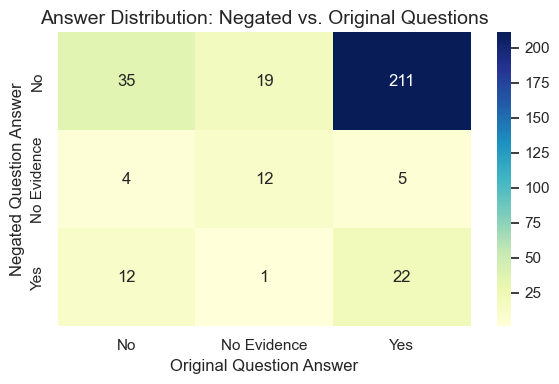

In [119]:
# Merge the original and negated evaluation results on DOI
merged_df = df.merge(eval_negated_df, on="doi", suffixes=("_orig", "_negated"))

# merged_df

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define inverse mapping
inverse_map = {
    "Yes": "No",
    "No": "Yes",
    "No Evidence": "No Evidence"
}

# Compute counts
total = len(merged_df)
correct_inverse = sum(
    (row["model_answer_negated"] == inverse_map.get(row["model_answer_orig"]))
    for _, row in merged_df.iterrows()
)

exact_match = sum(
    row["model_answer_negated"] == row["model_answer_orig"]
    for _, row in merged_df.iterrows()
)

# Ratios
inverse_ratio = correct_inverse / total
exact_match_ratio = exact_match / total

# Print results
print(f"Total samples: {total}")
print(f"Inverse-consistent pairs: {correct_inverse} ({inverse_ratio:.2%})")
print(f"Identical answers (no change): {exact_match} ({exact_match_ratio:.2%})")
print(f"Others (neither identical nor inverted): {total - correct_inverse - exact_match} ({(1 - inverse_ratio - exact_match_ratio):.2%})\n")




# Step 1: Count transitions from original to negated answers
grouped_counts = merged_df.groupby(
    ["model_answer_orig", "model_answer_negated"]
).size().reset_index(name="count")

# Step 2: Create transition matrix (each row = original answer, each column = negated answer)
transition_matrix = grouped_counts.pivot(
    index="model_answer_orig",
    columns="model_answer_negated",
    values="count"
).fillna(0).astype(int)

# Step 3: Define correct inversion logic
def is_correct_inverse(orig, neg):
    return (orig == "Yes" and neg == "No") or \
           (orig == "No" and neg == "Yes") or \
           (orig == "No Evidence" and neg == "No Evidence")

grouped_counts["is_correct_inverse"] = grouped_counts.apply(
    lambda row: is_correct_inverse(row["model_answer_orig"], row["model_answer_negated"]),
    axis=1
)

# Step 4: Aggregate inversion correctness and total transitions
summary = (
    grouped_counts
    .groupby("model_answer_orig")
    .agg(
        total_transitions=("count", "sum"),
        correct_inversions=("is_correct_inverse", lambda x: grouped_counts.loc[x.index, "count"][x].sum())
    )
    .reset_index()
)

# Step 5: Combine transition counts and inversion stats
summary_full = summary.merge(transition_matrix, on="model_answer_orig", how="left")
summary_full["inverse_accuracy"] = summary_full["correct_inversions"] / summary_full["total_transitions"]

# Step 6: Show the final summary
print(summary_full)



# Step 1: create confusion matrix-style cross-tab
conf_matrix = pd.crosstab(
    merged_df["model_answer_negated"],    # y-axis
    merged_df["model_answer_orig"],       # x-axis
    rownames=["Negated Question Answer"],
    colnames=["Original Question Answer"]
)

# Step 2: plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", cbar=True)

plt.title("Answer Distribution: Negated vs. Original Questions", fontsize=14)
plt.xlabel("Original Question Answer")
plt.ylabel("Negated Question Answer")
plt.tight_layout()
plt.show()


**Observations:**

(1) Inverse-consistency = 235/321 = 73.21%. 

(2) Consistency is lower when the original answer is "No" .

eg. (original) "Do non-aspirin NSAIDs reduce the risk of developing Parkinson's disease?" --> model_answer: no (ground truth: yes)

(negated) "Do non-aspirin NSAIDs increase the risk of developing Parkinson's disease?" --> model_answer: no (ground truth: no)

(This is also an example where negated question is easier to answer)

===== Accuracy Summary =====
Total Samples         : 321
Original Accuracy     : 242 / 321 = 75.39%
Negated Accuracy      : 262 / 321 = 81.62%
Correct → Correct     : 212
Correct → Incorrect   : 30
Incorrect → Correct   : 50
Incorrect → Incorrect : 29


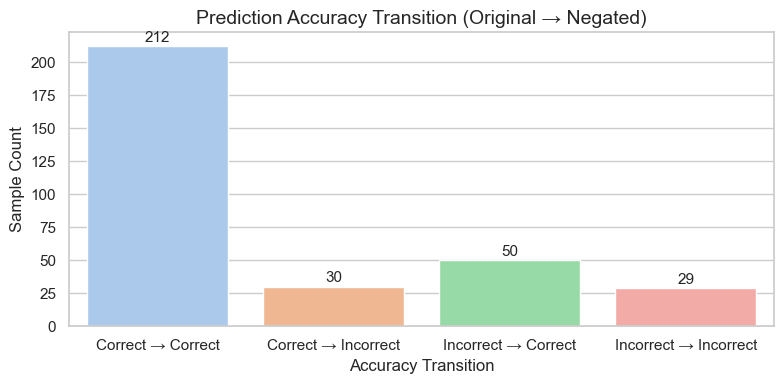

In [120]:
# Step 1: Check correctness of each prediction
merged_df["orig_correct"] = merged_df["model_answer_orig"] == merged_df["original_answer"]
merged_df["negated_correct"] = merged_df["model_answer_negated"] == merged_df["expected_answer"]

# Step 2: Basic accuracy stats
total = len(merged_df)
orig_correct_count = merged_df["orig_correct"].sum()
negated_correct_count = merged_df["negated_correct"].sum()

# Step 3: Accuracy transitions
both_correct = ((merged_df["orig_correct"]) & (merged_df["negated_correct"])).sum()
now_wrong = ((merged_df["orig_correct"]) & (~merged_df["negated_correct"])).sum()
now_correct = ((~merged_df["orig_correct"]) & (merged_df["negated_correct"])).sum()
both_wrong = ((~merged_df["orig_correct"]) & (~merged_df["negated_correct"])).sum()

# Step 4: Print summary
print("===== Accuracy Summary =====")
print(f"Total Samples         : {total}")
print(f"Original Accuracy     : {orig_correct_count} / {total} = {orig_correct_count / total:.2%}")
print(f"Negated Accuracy      : {negated_correct_count} / {total} = {negated_correct_count / total:.2%}")
print(f"Correct → Correct     : {both_correct}")
print(f"Correct → Incorrect   : {now_wrong}")
print(f"Incorrect → Correct   : {now_correct}")
print(f"Incorrect → Incorrect : {both_wrong}")



import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the accuracy transition counts
# Make sure the following variables are already defined:
# both_correct, now_wrong, now_correct, both_wrong

# Step 1: Create dataframe with updated labels
transition_data = pd.DataFrame({
    "Transition": [
        "Correct → Correct",
        "Correct → Incorrect",
        "Incorrect → Correct",
        "Incorrect → Incorrect"
    ],
    "Count": [both_correct, now_wrong, now_correct, both_wrong]
})

# Step 2: Plot setup
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
sns.barplot(data=transition_data, x="Transition", y="Count", palette="pastel")

# Step 3: Annotate bars
for i, row in transition_data.iterrows():
    plt.text(i, row["Count"] + 1, str(row["Count"]), ha='center', va='bottom', fontsize=11)

# Step 4: Labeling
plt.title("Prediction Accuracy Transition (Original → Negated)", fontsize=14)
plt.ylabel("Sample Count")
plt.xlabel("Accuracy Transition")
plt.xticks(rotation=0)
plt.tight_layout()

# Step 5: Show plot
plt.show()
   

**Observations:**

(1) Original accuracy is 242 / 321 = 75.39%. (This is higher than the previous overall accuracy possibly because we filtered out not-inferrable negated questions, which might be harder/more complex ones)

(2) Negated accuracy is 262 / 321 = 81.62%. Some cases change from incorrect to correct. It is possibly because negated questions are sometimes easier to answer (see the example above)


------

**CoT prompt steps:** 

(1) Ask the negated question --> get [initial_answer1]

(2) ask the original question --> get [initial_answer2]

(3) ask if there's logic contradiction between the two answers 

(4) ask to solve the inconsistency and give the final answers

(5) give a few examples

In [124]:
json_path = "/Users/pql/Desktop/proj/eval_on_negated_with_cot.json"  # Replace with desired output path
with open(json_path, 'rb') as f:
    eval_negated_CoT = json.load(f)

eval_negated_CoT = pd.DataFrame.from_dict(eval_negated_CoT, orient="index")
# eval_negated_CoT
eval_negated_CoT.to_csv("eval_negated_CoT.csv")
# eval_negated_CoT

Number of Answers Changed after CoT: 6 (1.87%)
===== Consistency Analysis =====
Total merged samples: 321
Consistency (Original vs Negated Initial1): 223 / 321 = 69.47%
Consistency (Original vs Negated Final after CoT): 229 / 321 = 71.34%
Consistency (Original model_answer vs model_initial_answer2): 245 / 321 = 76.32%


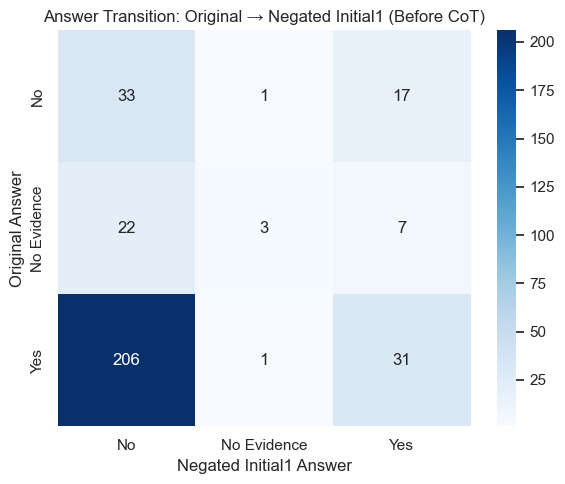

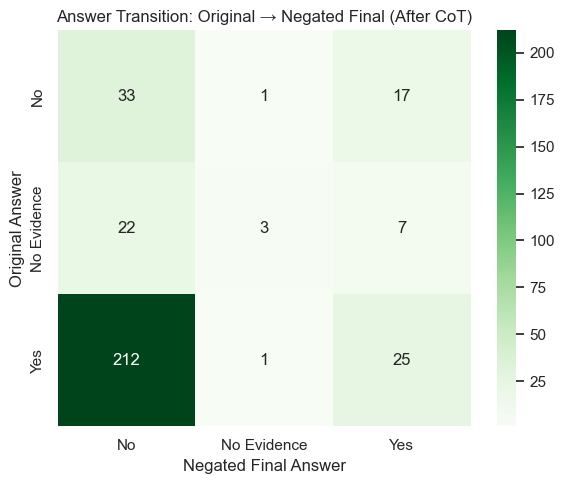

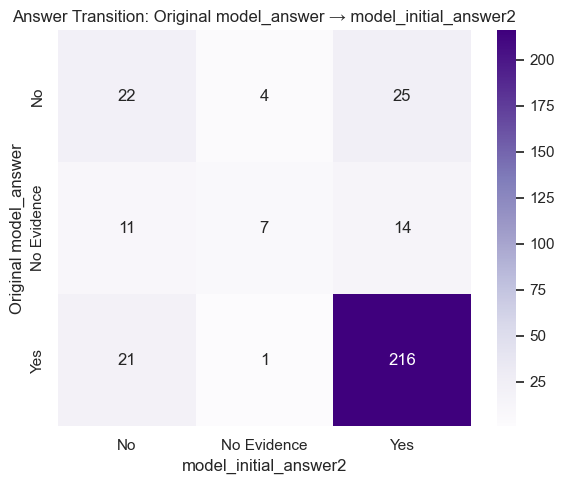

In [129]:
import pandas as pd

# Assuming your DataFrame is already named eval_negated_CoT

# Step 1: Check if the final answer changed compared to the initial answer
eval_negated_CoT["answer_changed"] = eval_negated_CoT["model_initial_answer1"] != eval_negated_CoT["model_final_answer_for_negated"]

# Step 2: Check initial accuracy (before CoT reasoning)
eval_negated_CoT["initial_correct"] = eval_negated_CoT["model_initial_answer1"] == eval_negated_CoT["expected_answer_negated"]

# Step 3: Check final accuracy (after CoT reasoning)
eval_negated_CoT["final_correct"] = eval_negated_CoT["model_final_answer_for_negated"] == eval_negated_CoT["expected_answer_negated"]

# Step 4: Summary statistics
total_samples = len(eval_negated_CoT)
num_changed = eval_negated_CoT["answer_changed"].sum()
initial_correct = eval_negated_CoT["initial_correct"].sum()
final_correct = eval_negated_CoT["final_correct"].sum()

#print("===== Negated Question CoT Analysis Summary =====")
#print(f"Total Samples: {total_samples}")
print(f"Number of Answers Changed after CoT: {num_changed} ({num_changed/total_samples:.2%})")
#print(f"Initial Accuracy (before CoT): {initial_correct}/{total_samples} = {initial_correct/total_samples:.2%}")
#print(f"Final Accuracy (after CoT): {final_correct}/{total_samples} = {final_correct/total_samples:.2%}")

# Step 5: Transition breakdown
transition_table = pd.crosstab(eval_negated_CoT["initial_correct"], eval_negated_CoT["final_correct"], rownames=["Initial Correct"], colnames=["Final Correct"])

#print("\n===== Accuracy Transition Table =====")
#print(transition_table)




import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Merge df and eval_negated_CoT by 'doi'
merged = pd.merge(df, eval_negated_CoT, on="doi", how="inner")

# print(f"Merged samples: {len(merged)}")

# Step 2: Define inversion logic (for consistency between original and negated)
def is_inverted(ans1, ans2):
    if ans1 == "Yes" and ans2 == "No":
        return True
    if ans1 == "No" and ans2 == "Yes":
        return True
    if ans1 == "No evidence" and ans2 == "No evidence":
        return True
    return False

# Step 3: Calculate consistency flags
merged["consistency_before_CoT"] = merged.apply(lambda x: is_inverted(x["model_answer"], x["model_initial_answer1"]), axis=1)
merged["consistency_after_CoT"] = merged.apply(lambda x: is_inverted(x["model_answer"], x["model_final_answer_for_negated"]), axis=1)
merged["original_vs_initial2_consistency"] = merged["model_answer"] == merged["model_initial_answer2"]

# Step 4: Basic stats
total = len(merged)
before_consistent = merged["consistency_before_CoT"].sum()
after_consistent = merged["consistency_after_CoT"].sum()
original_vs_initial2_consistent = merged["original_vs_initial2_consistency"].sum()

print("===== Consistency Analysis =====")
print(f"Total merged samples: {total}")
print(f"Consistency (Original vs Negated Initial1): {before_consistent} / {total} = {before_consistent/total:.2%}")
print(f"Consistency (Original vs Negated Final after CoT): {after_consistent} / {total} = {after_consistent/total:.2%}")
print(f"Consistency (Original model_answer vs model_initial_answer2): {original_vs_initial2_consistent} / {total} = {original_vs_initial2_consistent/total:.2%}")

# Step 5: Heatmaps
# Heatmap: Original vs Negated Initial (Before CoT)
confusion_before = pd.crosstab(merged["model_answer"], merged["model_initial_answer1"])
plt.figure(figsize=(6,5))
sns.heatmap(confusion_before, annot=True, fmt="d", cmap="Blues")
plt.title("Answer Transition: Original → Negated Initial1 (Before CoT)")
plt.xlabel("Negated Initial1 Answer")
plt.ylabel("Original Answer")
plt.tight_layout()
plt.show()

# Heatmap: Original vs Negated Final (After CoT)
confusion_after = pd.crosstab(merged["model_answer"], merged["model_final_answer_for_negated"])
plt.figure(figsize=(6,5))
sns.heatmap(confusion_after, annot=True, fmt="d", cmap="Greens")
plt.title("Answer Transition: Original → Negated Final (After CoT)")
plt.xlabel("Negated Final Answer")
plt.ylabel("Original Answer")
plt.tight_layout()
plt.show()

# Heatmap: Original vs Initial2 (i.e., re-answered original question)
confusion_initial2 = pd.crosstab(merged["model_answer"], merged["model_initial_answer2"])
plt.figure(figsize=(6,5))
sns.heatmap(confusion_initial2, annot=True, fmt="d", cmap="Purples")
plt.title("Answer Transition: Original model_answer → model_initial_answer2")
plt.xlabel("model_initial_answer2")
plt.ylabel("Original model_answer")
plt.tight_layout()
plt.show()


**Observations**:

(1) The consistency between origin answer and [initial_answer_2] (which should be identical) is 245 / 321 = 76.32%. (not very stable, may be affected by the prompt/..)

(2) 6(1.87%) answers changed after CoT. The inverse consistency is 223 / 321 = 69.47% before CoT and 229 / 321 = 71.34% after CoT.

Merged samples: 321
===== Answer Accuracy Comparison =====
Original Question Accuracy      : 242 / 321 = 75.39%
Initial2 Re-Answer Accuracy     : 254 / 321 = 79.13%
Negated Before CoT Accuracy     : 260 / 321 = 81.00%
Negated After CoT Accuracy      : 266 / 321 = 82.87%

===== Transition Table (Before → After) =====
After CoT Correct   False  True 
Before CoT Correct              
False                  55      6
True                    0    260


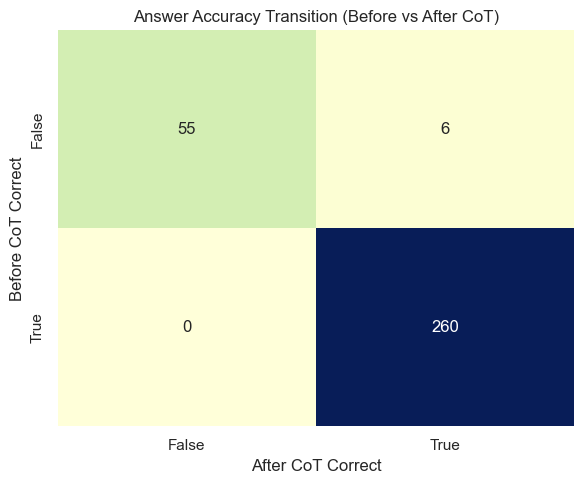

In [127]:
# Step 1: Merge again to ensure working with aligned data
merged = pd.merge(df, eval_negated_CoT, on="doi", how="inner")
print(f"Merged samples: {len(merged)}")

# Step 2: Define correctness for CoT before and after
merged["negated_correct_before_CoT"] = merged["model_initial_answer1"] == merged["expected_answer_negated"]
merged["negated_correct_after_CoT"] = merged["model_final_answer_for_negated"] == merged["expected_answer_negated"]
# Step 2 (extended): Define correctness for model_initial_answer2
merged["initial2_correct"] = merged["model_initial_answer2"] == merged["original_answer"]


# Step 3: Count correct predictions
total = len(merged)
orig_correct = merged["answer_match"].sum()
negated_correct_before = merged["negated_correct_before_CoT"].sum()
negated_correct_after = merged["negated_correct_after_CoT"].sum()
initial2_correct = merged["initial2_correct"].sum()

# Step 4: Print summary
print("===== Answer Accuracy Comparison =====")
print(f"Original Question Accuracy      : {orig_correct} / {total} = {orig_correct / total:.2%}")
print(f"Initial2 Re-Answer Accuracy     : {initial2_correct} / {total} = {initial2_correct / total:.2%}")
print(f"Negated Before CoT Accuracy     : {negated_correct_before} / {total} = {negated_correct_before / total:.2%}")
print(f"Negated After CoT Accuracy      : {negated_correct_after} / {total} = {negated_correct_after / total:.2%}")


# Step 5 (Optional): Show transition breakdown
transition_table = pd.crosstab(
    merged["negated_correct_before_CoT"],
    merged["negated_correct_after_CoT"],
    rownames=["Before CoT Correct"],
    colnames=["After CoT Correct"]
)

print("\n===== Transition Table (Before → After) =====")
print(transition_table)

import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create the confusion matrix for correctness transitions
transition_matrix = pd.crosstab(
    merged["negated_correct_before_CoT"],
    merged["negated_correct_after_CoT"],
    rownames=["Before CoT Correct"],
    colnames=["After CoT Correct"]
)

# Step 2: Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(transition_matrix, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title("Answer Accuracy Transition (Before vs After CoT)")
plt.tight_layout()
plt.show()


**Observations**:

(1) Negated accuracy is higher than original accuracy. (similar result as before)

(2) CoT slightly increases negated accuracy.